# Cardiotocograms (CTG) classification

|Feature| Description|
|---|---|
|LB | Fetal Heart Rate baseline (beats per minute)|
|AC | # of accelerations per second| 
|FM | # of fetal movements per second| 
|UC | # of uterine contractions per second| 
|DL | # of light decelerations per second| 
|DS | # of severe decelerations per second| 
|DP | # of prolongued decelerations per second| 
|ASTV | percentage of time with abnormal short term variability| 
|MSTV | mean value of short term variability| 
|ALTV | percentage of time with abnormal long term variability| 
|MLTV | mean value of long term variability| 
|Width | width of FHR histogram| 
|Min | minimum of FHR histogram| 
|Max | Maximum of FHR histogram| 
|Nmax | # of histogram peaks| 
|Nzeros | # of histogram zeros| 
|Mode | histogram mode| 
|Mean | histogram mean| 
|Median | histogram median| 
|Variance | histogram variance| 
|Tendency | histogram tendency| 
|CLASS | FHR pattern class code 1 to 10 for classes A to SUSP| 
|NSP | fetal state class code (1=Normal; 2=Suspect; 3=Pathologic)|

In [189]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, make_scorer
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [121]:
df = pd.read_csv("CTG.csv")

In [122]:
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,2.4,64,62,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,10.4,130,68,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,13.4,130,68,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,23.0,117,53,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,19.9,117,53,170,9,0,137,136,138,11,1,2,1


In [123]:
df.dtypes

LB            int64
AC          float64
FM          float64
UC          float64
DL          float64
DS          float64
DP          float64
ASTV          int64
MSTV        float64
ALTV          int64
MLTV        float64
Width         int64
Min           int64
Max           int64
Nmax          int64
Nzeros        int64
Mode          int64
Mean          int64
Median        int64
Variance      int64
Tendency      int64
CLASS         int64
NSP           int64
dtype: object

In [124]:
df.isnull().sum()

LB          0
AC          0
FM          0
UC          0
DL          0
DS          0
DP          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
CLASS       0
NSP         0
dtype: int64

## DATA WRANGLING

In [125]:
df.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,4.509878,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,3.026883,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,2.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,4.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,7.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,10.000000,3.000000


So, first thing that I notice about the data is that the range of values varies a lot among features: for example LB is in the order of 10^2 while AC is in the order of 10^-2. This characteristic may cause those classifiers that rely on the calculation of some form of distance to take decisions on how to split data to perform poorly. Eg SVM

In [126]:
values = df.NSP.value_counts()
sum_val = values.sum()

In [127]:
for i,val in enumerate(values,1):
  print("Class ",i,round((val/sum_val)*100,2))


Class  1 77.85
Class  2 13.88
Class  3 8.28


In [128]:
data = df.iloc[:,:-2]

Below, there is the correlation matrix between each feature. Features that have a correlation above 0.9 are:
 - mode and median (positive correlation)
 - mode and mean (positive correlation)
 - min and width (negative correlation)

If correlation is strong some features could be dropped because the majority of their information is de facto carried by the one they are strictly correlated to.

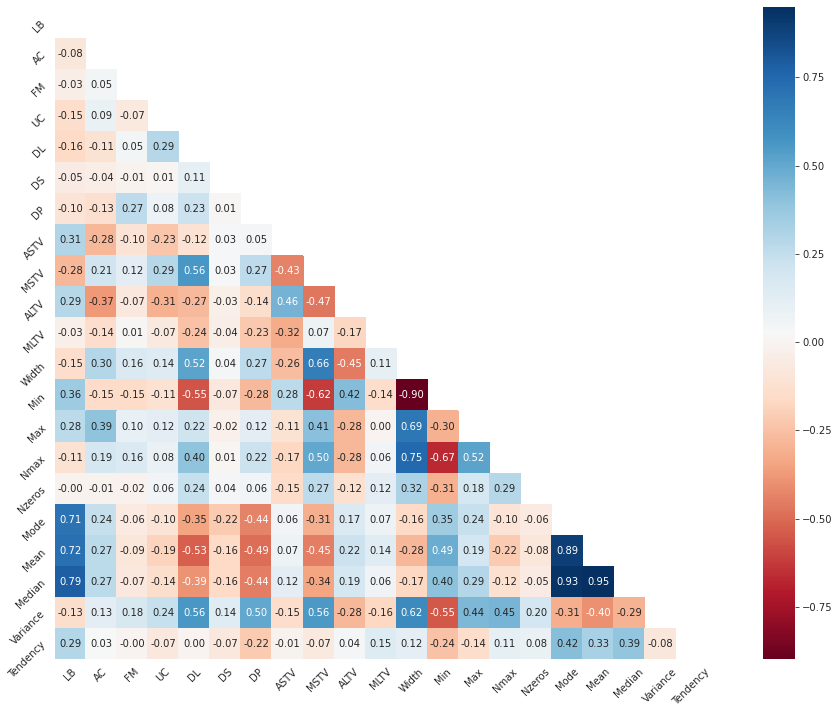

In [130]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(20,12))
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='.2f')
    plt.xticks(rotation=45, ha="center")
    plt.yticks(rotation=45, ha="right")

## DATA PREPROCESSING

I am going to merge class 1 and class 2 for two reasons: 

- class size
- scope of the classifier

Class 2 and 3 represent the minority of elements in the data. The little number of examples makes it difficult for the classifier to effectively identify those classes. By merging them I am going to obtain a larger class that is going to be easier for the classifier to recognize.
The second point is the most important. With this model I want to create a tool for doctors that can help them recognize when a patient is at risk of having a pathological conditions. This means that I want to notify the doctors when an instance belongs to class 2 as well as when it belongs to class 3. It follows that these two classes can be considered as one. I reckon that it would be even more helpful to provide a quantification of the probability that an element belongs to a class rather than another but that feature is not going to be included into this project. 

In [131]:
label = df.iloc[:,-1]

In [132]:
idxs = df['NSP'].apply(lambda x: -1 if x == 1 else 1)

### OUTLIER DETECTION

Outliers are values that are abnormally low or abnormally high given the distribution of the majority of data. They can be the product of errors, in which case they don't carry any information, or an actual rare instance of the process we want to model. In both cases they are data points that cannot be properly described and add noise to the model. Outliers are identified by applying thresholds on data. The way those thresholds are determined is subjective to the problem and preferences of the user

In [133]:
import scipy.stats
from IPython.display import display # Allows the use of display() for DataFrames

all_outliers = []

for feature in data.keys():
    
    # identify outliers using Tukey's method
    Q1 = np.percentile(data[feature], 25, axis=0)
    Q3 = np.percentile(data[feature], 75, axis=0)
    
    step = 1.5 * (Q3-Q1)
    
    print("Data points considered outliers for feature {}".format(feature))
    display(data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))])
    
    # save the outliers list to perform selected removal later of those rows being outliers for more than two class
    outliers = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))].index.tolist()
    
    all_outliers += outliers
    
    # thresholding the outliers to the 5th and the 95th percentile
    for x in outliers:
        scipy.stats.mstats.winsorize(data[feature], limits=0.05)
    

Data points considered outliers for feature LB


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature AC


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
181,138,0.017,0.000,0.005,0.000,0.0,0.0,35,5.3,0,4.5,148,52,200,11,2,146,157,161,72,1
497,130,0.016,0.084,0.002,0.000,0.0,0.0,34,2.1,0,3.0,132,50,182,8,0,159,151,155,25,1
529,142,0.019,0.085,0.000,0.000,0.0,0.0,32,2.3,0,0.0,144,56,200,10,0,170,158,162,37,1
530,142,0.016,0.071,0.000,0.002,0.0,0.0,32,3.1,0,1.6,149,51,200,10,0,167,154,160,55,1
531,142,0.016,0.060,0.004,0.000,0.0,0.0,38,1.3,0,0.0,130,68,198,5,0,180,173,177,14,1
552,136,0.016,0.000,0.004,0.000,0.0,0.0,35,4.9,0,5.2,148,52,200,11,2,146,159,162,74,1
630,134,0.017,0.002,0.004,0.000,0.0,0.0,48,2.2,0,0.0,120,50,170,5,0,160,150,155,28,1
1093,122,0.016,0.000,0.001,0.000,0.0,0.0,22,2.2,0,1.9,52,100,152,1,0,131,133,134,5,0
1094,122,0.018,0.000,0.002,0.000,0.0,0.0,22,2.5,0,2.2,52,100,152,1,0,136,132,134,6,0
1096,123,0.017,0.000,0.002,0.000,0.0,0.0,24,2.2,0,1.7,52,100,152,1,0,136,133,135,5,0


Data points considered outliers for feature FM


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
12,131,0.005,0.072,0.008,0.003,0.0,0.000,28,1.4,0,12.9,66,88,154,5,0,135,134,137,7,1
13,131,0.009,0.222,0.006,0.002,0.0,0.000,28,1.5,0,5.4,87,71,158,2,0,141,137,141,10,1
14,130,0.006,0.408,0.004,0.005,0.0,0.001,21,2.3,0,7.9,107,67,174,7,0,143,125,135,76,0
15,130,0.006,0.380,0.004,0.004,0.0,0.001,19,2.3,0,8.7,107,67,174,3,0,134,127,133,43,0
16,130,0.006,0.441,0.005,0.005,0.0,0.000,24,2.1,0,10.9,125,53,178,5,0,143,128,138,70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,130,0.000,0.009,0.006,0.000,0.0,0.000,72,2.6,5,1.5,27,124,151,1,0,130,127,131,1,-1
2083,130,0.000,0.009,0.008,0.000,0.0,0.000,73,2.1,12,1.4,27,124,151,2,0,128,127,130,1,-1
2099,133,0.000,0.009,0.005,0.000,0.0,0.000,72,2.1,11,2.5,60,91,151,10,0,136,132,136,1,1
2100,133,0.000,0.010,0.005,0.000,0.0,0.000,70,2.7,4,1.5,60,91,151,8,1,134,130,135,1,1


Data points considered outliers for feature UC


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1164,131,0.011,0.0,0.015,0.0,0.0,0.0,26,1.5,0,3.0,61,109,170,2,1,155,151,154,11,1


Data points considered outliers for feature DL


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0.0,0.002,26,5.9,0,0.0,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0.0,0.003,29,6.3,0,0.0,150,50,200,6,3,71,107,106,215,0
28,132,0.000,0.135,0.001,0.008,0.0,0.001,29,4.4,0,10.5,141,50,191,7,1,133,119,129,73,0
29,132,0.000,0.099,0.000,0.012,0.0,0.000,26,6.0,0,5.0,143,50,193,10,0,133,113,117,89,0
30,132,0.000,0.108,0.002,0.010,0.0,0.000,26,4.5,0,12.5,149,50,199,9,0,133,120,126,56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,128,0.000,0.007,0.008,0.009,0.0,0.000,63,3.0,0,1.5,96,64,160,5,2,127,109,128,24,0
2047,128,0.000,0.008,0.007,0.010,0.0,0.000,63,2.8,0,1.4,96,64,160,3,0,127,114,129,16,0
2048,128,0.000,0.000,0.008,0.010,0.0,0.000,63,4.2,0,0.0,90,66,156,5,0,69,73,118,128,0
2111,136,0.000,0.004,0.009,0.009,0.0,0.002,63,2.2,0,1.9,86,67,153,6,0,134,112,123,71,1


Data points considered outliers for feature DS


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1488,132,0.002,0.000,0.008,0.000,0.001,0.001,31,1.4,0,11.5,102,61,163,5,0,99,121,129,94,1
1489,132,0.000,0.000,0.006,0.000,0.001,0.001,32,1.3,0,13.6,91,60,151,1,1,99,116,125,72,1
1791,121,0.000,0.001,0.004,0.010,0.001,0.000,66,2.1,0,6.4,105,55,160,7,0,67,85,92,109,-1
1792,121,0.000,0.001,0.003,0.011,0.001,0.000,67,2.1,0,0.0,102,55,157,4,1,67,81,87,89,-1
1793,121,0.000,0.001,0.005,0.012,0.001,0.000,66,2.1,0,0.0,102,55,157,5,1,67,83,90,98,-1
1794,121,0.000,0.001,0.003,0.010,0.001,0.000,68,2.1,0,0.0,102,55,157,3,1,67,79,82,83,-1
1795,121,0.000,0.000,0.004,0.009,0.001,0.000,70,1.9,0,0.0,102,55,157,6,2,67,76,79,68,-1


Data points considered outliers for feature DP


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0.0,0.002,26,5.9,0,0.0,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0.0,0.003,29,6.3,0,0.0,150,50,200,6,3,71,107,106,215,0
14,130,0.006,0.408,0.004,0.005,0.0,0.001,21,2.3,0,7.9,107,67,174,7,0,143,125,135,76,0
15,130,0.006,0.380,0.004,0.004,0.0,0.001,19,2.3,0,8.7,107,67,174,3,0,134,127,133,43,0
17,131,0.002,0.383,0.003,0.005,0.0,0.002,18,2.4,0,13.9,107,67,174,5,0,134,125,132,45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,128,0.000,0.002,0.007,0.006,0.0,0.002,65,2.5,0,0.0,129,63,192,6,0,104,94,115,28,0
2039,128,0.000,0.003,0.007,0.006,0.0,0.002,65,2.5,0,0.0,129,63,192,5,0,114,97,116,25,0
2110,136,0.000,0.004,0.008,0.007,0.0,0.001,64,2.2,0,3.0,85,67,152,5,0,134,119,131,45,1
2111,136,0.000,0.004,0.009,0.009,0.0,0.002,63,2.2,0,1.9,86,67,153,6,0,134,112,123,71,1


Data points considered outliers for feature ASTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature MSTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0.0,0.002,26,5.9,0,0.0,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0.0,0.003,29,6.3,0,0.0,150,50,200,6,3,71,107,106,215,0
28,132,0.000,0.135,0.001,0.008,0.0,0.001,29,4.4,0,10.5,141,50,191,7,1,133,119,129,73,0
29,132,0.000,0.099,0.000,0.012,0.0,0.000,26,6.0,0,5.0,143,50,193,10,0,133,113,117,89,0
30,132,0.000,0.108,0.002,0.010,0.0,0.000,26,4.5,0,12.5,149,50,199,9,0,133,120,126,56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,129,0.000,0.002,0.005,0.013,0.0,0.000,58,3.9,0,0.0,158,72,230,10,1,113,90,124,28,-1
2034,129,0.000,0.001,0.006,0.005,0.0,0.002,67,3.3,0,0.0,129,63,192,7,0,105,80,107,14,-1
2048,128,0.000,0.000,0.008,0.010,0.0,0.000,63,4.2,0,0.0,90,66,156,5,0,69,73,118,128,0
2049,125,0.005,0.015,0.007,0.000,0.0,0.000,66,4.1,5,0.3,23,123,146,0,0,133,126,134,1,0


Data points considered outliers for feature ALTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120,0.000,0.000,0.000,0.000,0.0,0.0,73,0.5,43,2.4,64,62,126,2,0,120,137,121,73,1
24,128,0.000,0.000,0.003,0.000,0.0,0.0,86,0.3,79,2.9,16,114,130,0,0,128,126,129,0,1
25,124,0.000,0.000,0.000,0.000,0.0,0.0,86,0.3,72,4.0,12,118,130,1,0,124,124,125,0,0
27,124,0.000,0.000,0.000,0.000,0.0,0.0,87,0.2,71,3.4,10,118,128,0,0,124,123,125,0,0
53,150,0.000,0.001,0.000,0.001,0.0,0.0,61,0.5,40,6.2,31,130,161,2,0,154,152,154,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,136,0.000,0.001,0.008,0.000,0.0,0.0,78,0.4,36,7.1,36,113,149,3,0,139,137,139,1,1
2114,137,0.000,0.000,0.007,0.000,0.0,0.0,81,0.4,33,6.3,31,121,152,2,0,146,143,145,1,1
2115,140,0.000,0.000,0.006,0.000,0.0,0.0,83,0.2,48,5.4,20,132,152,2,0,145,145,146,0,0
2116,140,0.004,0.000,0.004,0.000,0.0,0.0,80,0.2,36,2.2,18,140,158,1,0,147,148,149,1,0


Data points considered outliers for feature MLTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
3,134,0.003,0.000,0.008,0.003,0.0,0.0,16,2.4,0,23.0,117,53,170,11,0,137,134,137,13,1
10,151,0.000,0.000,0.001,0.001,0.0,0.0,64,1.9,9,27.6,130,56,186,2,0,150,148,151,9,1
11,150,0.000,0.000,0.001,0.001,0.0,0.0,64,2.0,8,29.5,130,56,186,5,0,150,148,151,10,1
33,120,0.008,0.103,0.001,0.001,0.0,0.0,28,3.4,0,21.7,126,55,181,13,0,121,124,126,25,0
35,120,0.006,0.109,0.007,0.000,0.0,0.0,27,3.7,0,24.2,144,51,195,11,0,125,124,126,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,133,0.000,0.000,0.007,0.000,0.0,0.0,22,1.6,0,21.3,47,105,152,1,0,138,135,138,5,1
1580,132,0.000,0.000,0.010,0.000,0.0,0.0,16,2.5,0,33.5,105,54,159,9,1,136,131,134,15,1
1584,132,0.000,0.000,0.006,0.000,0.0,0.0,35,1.3,0,27.4,71,79,150,4,0,133,135,137,9,1
1592,134,0.000,0.000,0.010,0.000,0.0,0.0,27,2.8,8,26.1,74,89,163,7,1,138,134,138,13,0


Data points considered outliers for feature Width


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature Min


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature Max


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1544,149,0.000,0.000,0.009,0.008,0.0,0.000,42,2.5,23,8.2,162,51,213,4,0,156,142,154,87,0
1615,144,0.001,0.049,0.001,0.009,0.0,0.000,65,3.6,0,1.7,143,67,210,7,1,145,108,149,38,0
1619,142,0.003,0.048,0.003,0.006,0.0,0.001,66,3.5,0,0.3,143,67,210,7,0,142,108,147,85,0
1620,142,0.002,0.054,0.001,0.007,0.0,0.000,64,4.0,0,0.4,143,67,210,9,2,142,109,150,54,0
1621,143,0.002,0.052,0.001,0.008,0.0,0.000,64,3.8,0,1.3,143,67,210,10,2,145,111,149,49,0
1674,110,0.003,0.000,0.006,0.004,0.0,0.000,64,1.7,0,6.3,176,62,238,13,1,107,103,107,35,-1
1676,110,0.003,0.000,0.007,0.004,0.0,0.000,63,2.4,0,1.8,176,62,238,10,1,98,101,105,59,-1
1677,110,0.004,0.000,0.009,0.005,0.0,0.000,63,2.7,0,1.8,176,62,238,9,0,95,98,106,61,-1
1678,110,0.003,0.000,0.008,0.004,0.0,0.000,64,2.1,0,5.6,176,62,238,10,0,107,101,108,33,-1
1679,110,0.004,0.001,0.009,0.004,0.0,0.000,64,2.2,0,5.3,176,62,238,7,0,107,103,109,42,-1


Data points considered outliers for feature Nmax


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
20,129,0.000,0.340,0.004,0.002,0.0,0.003,30,2.1,0,8.5,128,54,182,13,0,129,104,120,138,0
33,120,0.008,0.103,0.001,0.001,0.0,0.000,28,3.4,0,21.7,126,55,181,13,0,121,124,126,25,0
43,116,0.004,0.012,0.005,0.000,0.0,0.000,40,1.8,1,11.4,142,52,194,13,1,125,122,125,9,0
46,122,0.000,0.005,0.008,0.003,0.0,0.000,17,4.9,0,22.1,145,53,198,13,0,127,122,126,25,0
114,129,0.007,0.009,0.009,0.012,0.0,0.000,22,5.2,0,0.0,145,50,195,13,1,139,122,129,86,0
120,123,0.000,0.000,0.005,0.004,0.0,0.000,47,1.1,31,7.4,130,59,189,14,2,129,122,127,15,0
376,141,0.005,0.023,0.002,0.001,0.0,0.000,53,1.0,28,5.2,123,57,180,13,0,154,149,154,10,1
441,142,0.001,0.003,0.001,0.002,0.0,0.000,55,1.3,10,10.0,115,52,167,15,3,148,142,147,20,1
463,120,0.006,0.001,0.001,0.000,0.0,0.000,51,1.3,3,11.1,113,59,172,16,1,117,127,129,23,0
492,120,0.012,0.085,0.001,0.000,0.0,0.000,36,2.1,0,0.9,140,53,193,13,0,167,151,158,56,1


Data points considered outliers for feature Nzeros


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1,132,0.006,0.000,0.006,0.003,0.0,0.000,17,2.1,0,10.4,130,68,198,6,1,141,136,140,12,0
2,133,0.003,0.000,0.008,0.003,0.0,0.000,16,2.1,0,13.4,130,68,198,5,1,141,135,138,13,0
5,134,0.001,0.000,0.010,0.009,0.0,0.002,26,5.9,0,0.0,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0.0,0.003,29,6.3,0,0.0,150,50,200,6,3,71,107,106,215,0
19,130,0.005,0.469,0.005,0.004,0.0,0.001,29,1.7,0,7.8,112,65,177,6,1,133,129,133,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,128,0.000,0.006,0.009,0.010,0.0,0.000,63,2.7,0,1.3,96,64,160,6,1,129,111,128,21,0
2046,128,0.000,0.007,0.008,0.009,0.0,0.000,63,3.0,0,1.5,96,64,160,5,2,127,109,128,24,0
2100,133,0.000,0.010,0.005,0.000,0.0,0.000,70,2.7,4,1.5,60,91,151,8,1,134,130,135,1,1
2103,133,0.000,0.001,0.008,0.000,0.0,0.000,70,2.0,6,2.5,68,91,159,7,1,133,132,135,3,0


Data points considered outliers for feature Mode


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0.0,0.002,26,5.9,0,0.0,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0.0,0.003,29,6.3,0,0.0,150,50,200,6,3,71,107,106,215,0
22,128,0.000,0.334,0.003,0.003,0.0,0.003,34,2.5,0,4.0,145,54,199,11,1,75,99,102,148,-1
385,129,0.009,0.048,0.003,0.001,0.0,0.000,36,1.5,0,17.9,134,61,195,11,2,186,154,147,157,0
386,129,0.011,0.088,0.005,0.000,0.0,0.000,36,1.5,0,0.0,99,99,198,3,1,186,163,169,106,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,133,0.000,0.001,0.005,0.003,0.0,0.003,60,2.8,0,8.1,105,60,165,5,0,100,98,107,45,0
1950,133,0.000,0.001,0.006,0.001,0.0,0.002,60,3.1,0,9.5,105,60,165,7,0,93,98,107,57,0
1951,133,0.000,0.000,0.007,0.001,0.0,0.003,60,3.2,0,0.0,105,60,165,6,0,93,94,102,42,0
1959,133,0.000,0.000,0.004,0.004,0.0,0.004,63,1.9,0,0.0,104,62,166,5,0,77,93,92,74,-1


Data points considered outliers for feature Mean


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
522,158,0.008,0.027,0.002,0.000,0.000,0.000,41,0.9,0,13.2,47,151,198,4,0,186,178,180,15,0
523,158,0.010,0.029,0.003,0.000,0.000,0.000,41,0.8,0,0.0,45,153,198,2,0,186,180,183,11,1
524,158,0.010,0.031,0.003,0.000,0.000,0.000,40,0.9,0,0.0,40,158,198,1,0,186,182,186,9,1
682,132,0.000,0.306,0.004,0.004,0.000,0.004,35,2.7,0,0.0,145,54,199,9,2,75,90,78,104,-1
683,132,0.000,0.298,0.002,0.002,0.000,0.004,37,2.3,0,0.0,111,54,165,5,1,75,87,77,86,-1
1349,128,0.000,0.028,0.004,0.004,0.000,0.004,36,2.6,0,0.0,120,54,174,8,2,75,91,79,108,-1
1681,110,0.003,0.002,0.006,0.007,0.000,0.002,68,3.1,0,0.0,133,60,193,8,0,91,83,95,42,-1
1682,110,0.004,0.000,0.009,0.007,0.000,0.002,68,3.0,0,0.0,133,60,193,7,0,91,87,95,41,-1
1683,110,0.003,0.002,0.007,0.007,0.000,0.002,68,3.0,0,0.0,133,60,193,6,0,91,84,94,45,-1
1684,110,0.002,0.003,0.002,0.009,0.000,0.002,68,3.2,0,0.0,124,63,187,6,1,91,78,94,39,-1


Data points considered outliers for feature Median


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
522,158,0.008,0.027,0.002,0.000,0.000,0.000,41,0.9,0,13.2,47,151,198,4,0,186,178,180,15,0
523,158,0.010,0.029,0.003,0.000,0.000,0.000,41,0.8,0,0.0,45,153,198,2,0,186,180,183,11,1
524,158,0.010,0.031,0.003,0.000,0.000,0.000,40,0.9,0,0.0,40,158,198,1,0,186,182,186,9,1
525,158,0.012,0.026,0.000,0.000,0.000,0.000,42,0.9,0,2.8,43,151,194,2,0,180,175,178,10,0
531,142,0.016,0.060,0.004,0.000,0.000,0.000,38,1.3,0,0.0,130,68,198,5,0,180,173,177,14,1
661,128,0.000,0.000,0.006,0.014,0.000,0.003,23,6.3,0,0.0,144,52,196,10,2,90,98,91,95,-1
682,132,0.000,0.306,0.004,0.004,0.000,0.004,35,2.7,0,0.0,145,54,199,9,2,75,90,78,104,-1
683,132,0.000,0.298,0.002,0.002,0.000,0.004,37,2.3,0,0.0,111,54,165,5,1,75,87,77,86,-1
1348,128,0.000,0.025,0.003,0.003,0.000,0.003,34,2.4,0,3.6,145,54,199,11,1,75,98,86,144,-1
1349,128,0.000,0.028,0.004,0.004,0.000,0.004,36,2.6,0,0.0,120,54,174,8,2,75,91,79,108,-1


Data points considered outliers for feature Variance


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120,0.000,0.000,0.000,0.000,0.0,0.000,73,0.5,43,2.4,64,62,126,2,0,120,137,121,73,1
5,134,0.001,0.000,0.010,0.009,0.0,0.002,26,5.9,0,0.0,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0.0,0.003,29,6.3,0,0.0,150,50,200,6,3,71,107,106,215,0
14,130,0.006,0.408,0.004,0.005,0.0,0.001,21,2.3,0,7.9,107,67,174,7,0,143,125,135,76,0
16,130,0.006,0.441,0.005,0.005,0.0,0.000,24,2.1,0,10.9,125,53,178,5,0,143,128,138,70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,133,0.001,0.000,0.008,0.004,0.0,0.003,62,2.2,0,0.0,133,52,185,5,0,125,100,108,114,0
1962,133,0.001,0.000,0.010,0.004,0.0,0.002,61,2.7,0,0.0,132,52,184,5,0,125,96,110,103,0
1963,133,0.000,0.000,0.010,0.003,0.0,0.002,61,2.8,0,0.0,98,57,155,4,0,125,95,103,95,0
2048,128,0.000,0.000,0.008,0.010,0.0,0.000,63,4.2,0,0.0,90,66,156,5,0,69,73,118,128,0


Data points considered outliers for feature Tendency


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


In [134]:
# Find the outliers for more than 2 features
all_outliers_df = pd.DataFrame(all_outliers)
outliers_count = all_outliers_df[0].value_counts()
multiple_features_outliers = outliers_count[outliers_count > 5].index
print("There are {} rows that have an outlier in at least four features.".format(multiple_features_outliers.shape))

There are (21,) rows that have an outlier in at least four features.


In [135]:
count = np.zeros(3)
for elem in multiple_features_outliers:
    count[fs_labels[elem] +1] +=1
print("There are {} outliers belonging to class -1 (healthy)\nThere are {} outliers belonging to class +1 (disease)".format(count[0], count[2]))

There are 2.0 outliers belonging to class -1 (healthy)
There are 19.0 outliers belonging to class +1 (disease)


In [136]:
# drop the hard outliers from both the data and the labels
good_data = data.drop(data.index[multiple_features_outliers]).reset_index(drop=True)
good_labels = fs_labels.drop(fs_labels.index[multiple_features_outliers]).reset_index(drop=True)

In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(good_data, good_labels, test_size=0.20, random_state=0)

# add development set for later analysis of features
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_train, y_train, test_size = 0.25, random_state=0)

In [138]:
print("X_train length :",len(X_train))
print("X_test length :",len(X_test))
print("X_train_dev length :",len(X_train_dev))
print("X_test_dev length :",len(X_test_dev))

X_train length : 1684
X_test length : 421
X_train_dev length : 1263
X_test_dev length : 421


In [139]:
from sklearn.metrics import fbeta_score
from time import time

def train_forest(X,y):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import make_scorer, fbeta_score
    from sklearn.model_selection import RandomizedSearchCV 
    
    classifier = RandomForestClassifier(n_estimators = 128, n_jobs = 4)
    parameters = {'max_depth': (8, 9, 10, 11), 'min_samples_split': (10, 30, 50, 70, 100)}
    f2_scorer = make_scorer(fbeta_score, greater_is_better=True, average='binary', 
                                   pos_label=1, beta=2.0)
    clf = RandomizedSearchCV(classifier, parameters, random_state=42, n_jobs=-1, n_iter=30, scoring=f2_scorer)
    
    t0 = time()
    clf.fit(X, y)
    t1 = time()
    
    print("Training done in {}s".format(t1 - t0))
    return clf.best_estimator_

clf = train_forest(X_train_dev, y_train_dev)

y_pred = clf.predict(X_test_dev)

print("F2 score for development set: {}".format(fbeta_score(y_test_dev, y_pred, average='binary', 
                                                                                pos_label=1, beta=2.0)))

Training done in 32.53999066352844s
F2 score for development set: 0.8823529411764706


The confusion matrix is a tool to measure the performance of the model. It allows for the quantification of false positives and false negatives.
- False positive: those instances belonging to the negative class (healthy) that are classified as positive (diseased). These are the types of error that I would care less about: if an healthy patient is marked as suspect new and more specific tests will be recommended and no harm will be done. Still, the number of these errors has to be kept as low as possible because of the costs linked with more exams.
- False negatives: diseased patients that are marked as healthy. These are the mistake that we need to more decisevily minimize as they are cases of the pathology that the model fails to recognize.

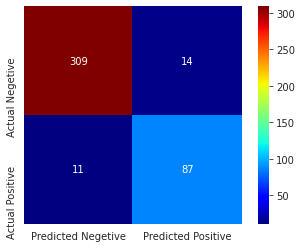

In [140]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_dev, y_pred)
labels_1 = ['Predicted Negetive', 'Predicted Positive']
labels_2 = ['Actual Negetive', 'Actual Positive']
with sns.axes_style('white'):
    plt.figure()
    ax = sns.heatmap(cm, square=True, xticklabels=labels_1, yticklabels=labels_2, annot=True, cmap=plt.cm.jet, fmt='.00f')    

In [141]:
from sklearn.metrics import precision_score, recall_score
print("Precision",precision_score(y_test_dev, y_pred))
print("Recall",recall_score(y_test_dev, y_pred))

Precision 0.8613861386138614
Recall 0.8877551020408163


In [142]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_dev, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.79


### FEATURE IMPORTANCE

In [143]:
# Measure feature importance

importances = clf.feature_importances_
features = data.keys()
features_importance = pd.DataFrame(importances, index=features, columns=['Importance'])
sorted_feat_imp = features_importance.sort_values('Importance', axis=0, ascending=False)

print(sorted_feat_imp)

          Importance
MSTV        0.184082
ASTV        0.136421
ALTV        0.086891
AC          0.079758
Mean        0.065196
DP          0.056828
Min         0.053004
UC          0.048470
Mode        0.044455
Median      0.044353
Width       0.038264
LB          0.035151
Variance    0.032381
MLTV        0.027327
Max         0.020038
Nmax        0.017167
FM          0.014244
DL          0.005413
Tendency    0.004900
Nzeros      0.004334
DS          0.001324


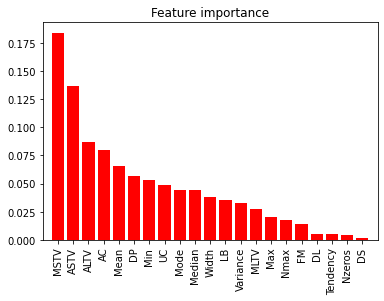

In [144]:
plt.figure()
plt.title('Feature importance')
tmp = sorted_feat_imp['Importance'].values.tolist()
plt.bar(range(data.shape[1]), tmp, color='r' )
plt.xticks(range(data.shape[1]), sorted_feat_imp.index, rotation=90, ha='center')
plt.xlim(-1, data.shape[1])
plt.show()

In [145]:
good_data_23f = good_data

ASTV_x_MSTV = np.multiply(good_data['ASTV'], good_data['MSTV'])
good_data_23f['ASTV_x_MSTV'] = ASTV_x_MSTV

ASTV_div_MSTV = np.divide(good_data['ASTV'], good_data['MSTV'])
good_data_23f['ASTV_div_MSTV'] = ASTV_div_MSTV

good_data_23f.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,ASTV_x_MSTV,ASTV_div_MSTV
count,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2.105000e+03,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000
mean,133.368171,0.003200,0.009187,0.004354,0.001822,9.501188e-07,0.000144,46.979097,1.313397,9.944893,8.259572,69.824703,93.980048,163.804751,4.036105,0.314964,138.034679,135.028979,138.484561,17.713539,0.330641,55.287411,65.556339
std,9.839725,0.003875,0.045932,0.002939,0.002879,3.081667e-05,0.000556,17.169324,0.853471,18.462010,5.603622,38.587121,29.430213,17.787384,2.932969,0.697012,15.235828,15.035213,13.892919,26.080876,0.603331,39.191408,74.523266
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,12.000000,0.200000,0.000000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,92.000000,0.000000,-1.000000,14.600000,3.142857
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000e+00,0.000000,32.000000,0.700000,0.000000,4.700000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,32.400000,20.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000e+00,0.000000,49.000000,1.200000,0.000000,7.500000,67.000000,94.000000,162.000000,3.000000,0.000000,139.000000,136.000000,140.000000,7.000000,0.000000,40.000000,38.571429
75%,141.000000,0.006000,0.003000,0.007000,0.003000,0.000000e+00,0.000000,61.000000,1.700000,11.000000,10.900000,99.000000,120.000000,174.000000,6.000000,0.000000,148.000000,146.000000,148.000000,23.000000,1.000000,62.700000,77.142857
max,160.000000,0.019000,0.481000,0.015000,0.015000,1.000000e-03,0.005000,87.000000,7.000000,91.000000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,277.200000,435.000000


In [146]:
# Separate data with new features in training, test and dev set
X_train_23f, X_test_23f, y_train_23f, y_test_23f = train_test_split(good_data_23f, good_labels, test_size=0.20, random_state=0)

# add development set for later analysis of features
X_train_dev_23f, X_test_dev_23f, y_train_dev_23f, y_test_dev_23f = train_test_split(X_train_23f, y_train_23f, test_size = 0.15, random_state=0)

In [147]:
clf_23f = train_forest(X_train_dev_23f, y_train_dev_23f)

y_pred_23f = clf_23f.predict(X_test_dev_23f)

print("F1 score for development set: {}".format(fbeta_score(y_test_dev, y_pred, average='binary',pos_label=1, beta=2.0)))

Training done in 32.511489391326904s
F1 score for development set: 0.8823529411764706


In [148]:
importances_23f = clf_23f.feature_importances_
features_23f = good_data_23f.keys()
features_importance_23f = pd.DataFrame(importances_23f, index=features_23f, columns=['Importance'])
sorted_feat_imp_23f = features_importance_23f.sort_values('Importance', axis=0, ascending=False)
print(sorted_feat_imp_23f)

               Importance
ASTV_div_MSTV    0.162928
MSTV             0.119870
ALTV             0.089230
ASTV             0.086930
ASTV_x_MSTV      0.064404
DP               0.055757
Mean             0.052121
Mode             0.049442
AC               0.039837
Min              0.036994
UC               0.035349
Median           0.033844
Width            0.030842
LB               0.030490
Variance         0.023390
MLTV             0.023095
Max              0.018315
FM               0.015673
Nmax             0.015537
DL               0.005623
Nzeros           0.005019
Tendency         0.004735
DS               0.000575


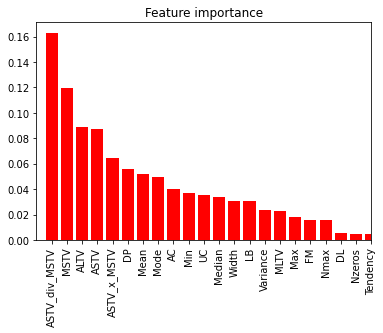

In [165]:
plt.figure()
plt.title('Feature importance')
tmp = sorted_feat_imp_23f['Importance'].values.tolist()
plt.bar(range(0,23), tmp, color='r' )
plt.xticks(range(0,23), sorted_feat_imp_23f.index, rotation=90, ha='center')
plt.xlim(-1, data.shape[1])
plt.show()

In [149]:
healthy_data = good_data_23f.loc[fs_labels == -1, :]
suspect_data = good_data_23f.loc[fs_labels == 1, :]
data_healthy_1st_5_feat = healthy_data[sorted_feat_imp_23f.index[0:5]]
data_suspect_1st_5_feat = suspect_data[sorted_feat_imp_23f.index[0:5]]

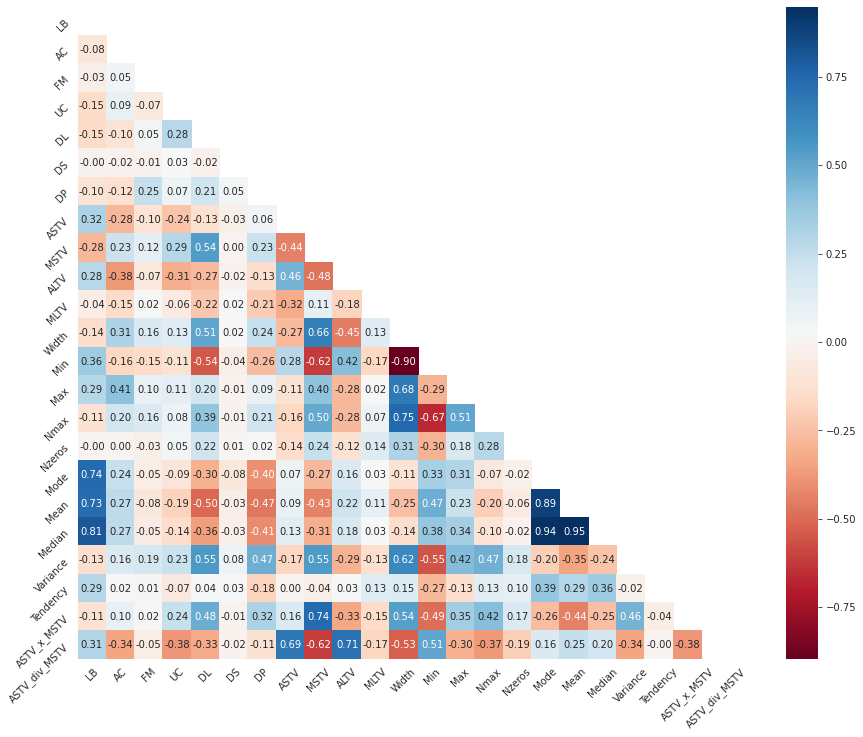

In [150]:
corr = good_data_23f.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(20,12))
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='.2f')
    plt.xticks(rotation=45, ha="center")
    plt.yticks(rotation=45, ha="right")

In [151]:
tmp = good_data_23f.drop(sorted_feat_imp_23f[sorted_feat_imp_23f['Importance'] < 0.01].index, axis=1)

In [152]:
tmp.head()

,LB,AC,FM,UC,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Mode,Mean,Median,Variance,ASTV_x_MSTV,ASTV_div_MSTV
0,120,0.000,0.0,0.000,0.0,73,0.5,43,2.4,64,62,126,2,120,137,121,73,36.5,146.000000
1,132,0.006,0.0,0.006,0.0,17,2.1,0,10.4,130,68,198,6,141,136,140,12,35.7,8.095238
2,133,0.003,0.0,0.008,0.0,16,2.1,0,13.4,130,68,198,5,141,135,138,13,33.6,7.619048
3,134,0.003,0.0,0.008,0.0,16,2.4,0,23.0,117,53,170,11,137,134,137,13,38.4,6.666667
4,132,0.007,0.0,0.008,0.0,16,2.4,0,19.9,117,53,170,9,137,136,138,11,38.4,6.666667


In [153]:
good_data_23f = tmp.drop('Mode', axis=1)

In [154]:
good_data_23f.head()

,LB,AC,FM,UC,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Mean,Median,Variance,ASTV_x_MSTV,ASTV_div_MSTV
0,120,0.000,0.0,0.000,0.0,73,0.5,43,2.4,64,62,126,2,137,121,73,36.5,146.000000
1,132,0.006,0.0,0.006,0.0,17,2.1,0,10.4,130,68,198,6,136,140,12,35.7,8.095238
2,133,0.003,0.0,0.008,0.0,16,2.1,0,13.4,130,68,198,5,135,138,13,33.6,7.619048
3,134,0.003,0.0,0.008,0.0,16,2.4,0,23.0,117,53,170,11,134,137,13,38.4,6.666667
4,132,0.007,0.0,0.008,0.0,16,2.4,0,19.9,117,53,170,9,136,138,11,38.4,6.666667


In [155]:
sorted_new = sorted_feat_imp_23f[sorted_feat_imp_23f['Importance'] < 0.01].index

In [156]:
X_train, X_test, y_train, y_test = train_test_split(good_data_23f, good_labels, test_size=0.20, random_state=0)

# add development set for later analysis of features
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)

In [157]:
from sklearn.metrics import fbeta_score
from time import time

def train_forest(X,y):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import make_scorer, fbeta_score
    from sklearn.model_selection import RandomizedSearchCV 
    
    classifier = RandomForestClassifier(n_estimators = 128, n_jobs = -1)
    parameters = {'max_depth': (8, 9, 10, 11), 'min_samples_split': (10, 30, 50, 70, 100)}
    f2_scorer = make_scorer(fbeta_score, greater_is_better=True, average='binary', 
                                   pos_label=1, beta=2.0)
    clf = RandomizedSearchCV(classifier, parameters, random_state=42, n_jobs=-1, n_iter=20, scoring=f2_scorer)
    
    t0 = time()
    clf.fit(X, y)
    t1 = time()
    
    print("Training done in {}s".format(t1 - t0))
    return clf.best_estimator_

clf = train_forest(X_train_dev, y_train_dev)

y_pred = clf.predict(X_test_dev)

print("F2 score for development set: {}".format(fbeta_score(y_test_dev, y_pred, average='binary', 
                                                                                pos_label=1, beta=2.0)))

Training done in 34.945122480392456s
F2 score for development set: 0.8904109589041096


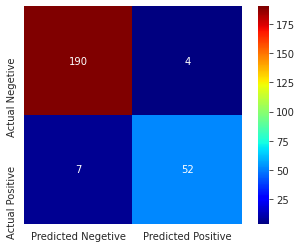

In [158]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_dev, y_pred)
labels_1 = ['Predicted Negetive', 'Predicted Positive']
labels_2 = ['Actual Negetive', 'Actual Positive']
with sns.axes_style('white'):
    plt.figure()
    ax = sns.heatmap(cm, square=True, xticklabels=labels_1, yticklabels=labels_2, annot=True, cmap=plt.cm.jet, fmt='.00f')  

In [159]:
from sklearn.metrics import precision_score, recall_score
print("Precision",precision_score(y_test_dev, y_pred))
print("Recall",recall_score(y_test_dev, y_pred))

Precision 0.9285714285714286
Recall 0.8813559322033898


In [160]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_dev, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.85


In [166]:
r_probs = [0 for _ in range(len(y_test_dev))]
rf_probs = clf.predict_proba(X_test_dev)
rf_probs = rf_probs[:, 1]

In [168]:
from sklearn.metrics import roc_curve, roc_auc_score
r_auc = roc_auc_score(y_test_dev, r_probs)
rf_auc = roc_auc_score(y_test_dev, rf_probs)

In [169]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))

Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.993


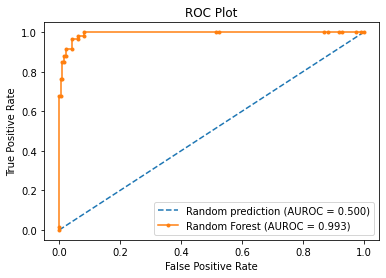

In [172]:
r_fpr, r_tpr, _ = roc_curve(y_test_dev, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test_dev, rf_probs)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [190]:
def kappa_score(y_act, y_pred):
  return cohen_kappa_score(y_act, y_pred)

Kappa = make_scorer(kappa_score)

In [192]:
kappa_score(clf.predict(X_test_dev),y_pred)

0.7881860465116279

In [181]:
def train_svm(X,y):
    from sklearn import svm
    from sklearn.metrics import make_scorer, fbeta_score
    from sklearn.model_selection import RandomizedSearchCV
    
    classifier = svm.SVC(verbose=True,probability=True)
    parameters = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf','linear']} 
    f2_scorer = make_scorer(fbeta_score, greater_is_better=True, average='binary', 
                                   pos_label=1, beta=2.0)
    clf1 = RandomizedSearchCV(classifier, parameters, random_state=42, n_jobs=-1, n_iter=20, scoring=f2_scorer)
    
    t0 = time()
    clf1.fit(X, y)
    t1 = time()
    
    print("Training done in {}s".format(t1 - t0))
    return clf1.best_estimator_

clf1 = train_svm(X_train_dev, y_train_dev)

y_pred = clf1.predict(X_test_dev)

print("F2 score for development set: {}".format(fbeta_score(y_test_dev, y_pred, average='binary', 
                                                                                pos_label=1, beta=2.0)))

[LibSVM]Training done in 151.23249626159668s
F2 score for development set: 0.763888888888889


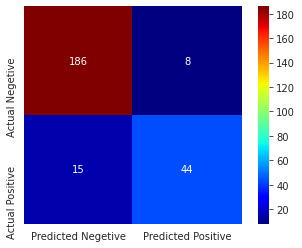

In [182]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_dev, y_pred)
labels_1 = ['Predicted Negetive', 'Predicted Positive']
labels_2 = ['Actual Negetive', 'Actual Positive']
with sns.axes_style('white'):
    plt.figure()
    ax = sns.heatmap(cm, square=True, xticklabels=labels_1, yticklabels=labels_2, annot=True, cmap=plt.cm.jet, fmt='.00f')  

In [183]:
from sklearn.metrics import precision_score, recall_score
print("Precision",precision_score(y_test_dev, y_pred))
print("Recall",recall_score(y_test_dev, y_pred))

Precision 0.8461538461538461
Recall 0.7457627118644068


In [184]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_dev, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.69


In [185]:
r_probs = [0 for _ in range(len(y_test_dev))]
rf_probs = clf1.predict_proba(X_test_dev)
rf_probs = rf_probs[:, 1]

In [186]:
r_auc = roc_auc_score(y_test_dev, r_probs)
rf_auc = roc_auc_score(y_test_dev, rf_probs)

In [187]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('SVC : AUROC = %.3f' % (rf_auc))

Random (chance) Prediction: AUROC = 0.500
SVC : AUROC = 0.962


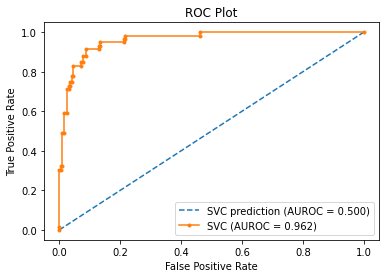

In [188]:
r_fpr, r_tpr, _ = roc_curve(y_test_dev, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test_dev, rf_probs)
plt.plot(r_fpr, r_tpr, linestyle='--', label='SVC prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='SVC (AUROC = %0.3f)' % rf_auc)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [191]:
kappa_score(y_test_dev,y_pred)

0.7348612566637809

## Thank You


---